## <center><b>Western University</b></center>
## <center><b>Faculty of Engineering</b></center>
## <center><b>Department of Electrical and Computer Engineering</b></center>

# <center><b>AISE 3350A FW24: Cyber-Physical Systems Theory</b></center>
# <center><b>Group 13 - Project</b></center>


Students:
- Jahangir (Janik) Abdullayev (251283871)
- Richard Augustine (251275608)
- Matthew Linders (251296414)
- Xander Chin  (251314531)
- Joseph Kim (251283383)


Segmentation of the M&Ms

In [1]:
import cv2
import matplotlib.pyplot as plt
from fastsam import FastSAM, FastSAMPrompt
import numpy as np

# For GUI
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from PIL import Image, ImageTk

%matplotlib inline

In [2]:
# Helper functions

def apply_mask(image, xy_array):
    # Create empty mask of same size as image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # Fill polygon defined by xy coordinates with ones
    cv2.fillPoly(mask, [xy_array], 1)
    
    # Apply mask to image
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    
    return masked_image

def check_circularity(contour):
    # Calculate area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Circularity using isoperimetric inequality
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    
    # Fit an ellipse and check ratio of axes
    if len(contour) >= 5:  # Need at least 5 points to fit ellipse
        ellipse = cv2.fitEllipse(contour)
        major_axis = max(ellipse[1])
        minor_axis = min(ellipse[1])
        axis_ratio = minor_axis / major_axis
    else:
        axis_ratio = 0
    
    # Combine metrics (weight them equally)
    final_score = (circularity + axis_ratio) / 2
    
    return final_score

def get_average_color(img):
    pixels = np.array(img)
    
    # Create mask for non-black pixels (where not all RGB values are 0)
    non_black_mask = ~np.all(pixels == 0, axis=2)
    
    # Only consider non-black pixels for average
    valid_pixels = pixels[non_black_mask]
    
    # Return average of valid pixels, or [0,0,0] if all pixels were black
    if len(valid_pixels) > 0:
        avg_rgb = np.round(valid_pixels.mean(axis=0)).astype(int)
        return avg_rgb
    return np.array([0, 0, 0])

# Predefined colors
def classify_color(rgb):
    color_dict = {
        'Red': [206, 38, 38],
        'Orange': [255, 120, 0],
        'Yellow': [255, 255, 0],
        'Green': [0, 204, 0],
        'Blue': [51, 153, 255],
        'Brown': [70, 5, 5],
        'White': [255, 255, 255]
    }
    
    distances = {
        color: np.sqrt(sum((rgb - np.array(ref_rgb))**2))
        for color, ref_rgb in color_dict.items()
    }
    
    return min(distances.items(), key=lambda x: x[1])[0]

In [3]:
def processImage(img_url):

    if img_url == None:
        print("No image loaded")
        return

    raw_image = cv2.cvtColor(cv2.imread(img_url), cv2.COLOR_BGR2RGB)
    plt.imshow(raw_image)
    plt.axis("off")
    plt.show()

    modelSAM = FastSAM("FastSAM-x.pt")

    everything_results = modelSAM(
        img_url,
        device="cpu",
        retina_masks=True,
        imgsz=384,
        conf=0.3,
        iou=0.9,
    )
    prompt_process = FastSAMPrompt(img_url, everything_results, device="cpu")

    # everything prompt
    prompt_process.everything_prompt()

    num_of_masks = len(everything_results[0])
    print(num_of_masks)

    # display images with matplotlib
    fig, axes = plt.subplots(nrows=int(np.ceil(num_of_masks / 6)), ncols=6, figsize=(10, 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    final_dict = {
        "Red": 0,
        "Orange": 0,
        "Yellow": 0,
        "Green": 0,
        "Blue": 0,
        "Brown": 0,
        "White": 0,
    }
    for index, r in enumerate(everything_results[0]):
        maskCoords = (r.masks.xy)[0]
        xy_array = np.array(maskCoords)

        CIRCULAR_THRESHOLD = 0.75
        
        # Checks if the mask is circular enough
        if(check_circularity(xy_array) > CIRCULAR_THRESHOLD):   
            contour = xy_array.reshape((-1, 1, 2)).astype(np.int32)
            # Create binary mask from contour
            mask = np.zeros(raw_image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [contour], 255)

            # Apply mask to image
            masked_image = cv2.bitwise_and(raw_image, raw_image, mask=mask)

            # Get bounding box just to determine region of interest
            x, y, w, h = cv2.boundingRect(contour)
            result_image = masked_image[y:y+h, x:x+w]

            # Get average RGB and classify it as a color
            avg_rgb = get_average_color(result_image)
            color_category = classify_color(avg_rgb)
            final_dict[color_category] += 1

            ax = axes[index]
            ax.axis("off")
            ax.imshow(result_image)

    print(final_dict)

    plt.tight_layout()
    plt.show()

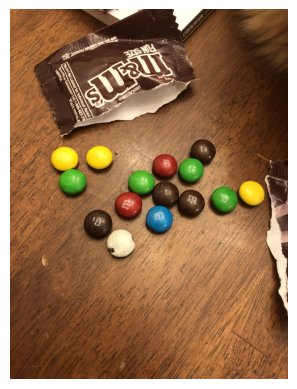

c:\Users\xande\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\nn\tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, m

24
{'Red': 2, 'Orange': 0, 'Yellow': 3, 'Green': 4, 'Blue': 1, 'Brown': 4, 'White': 1}


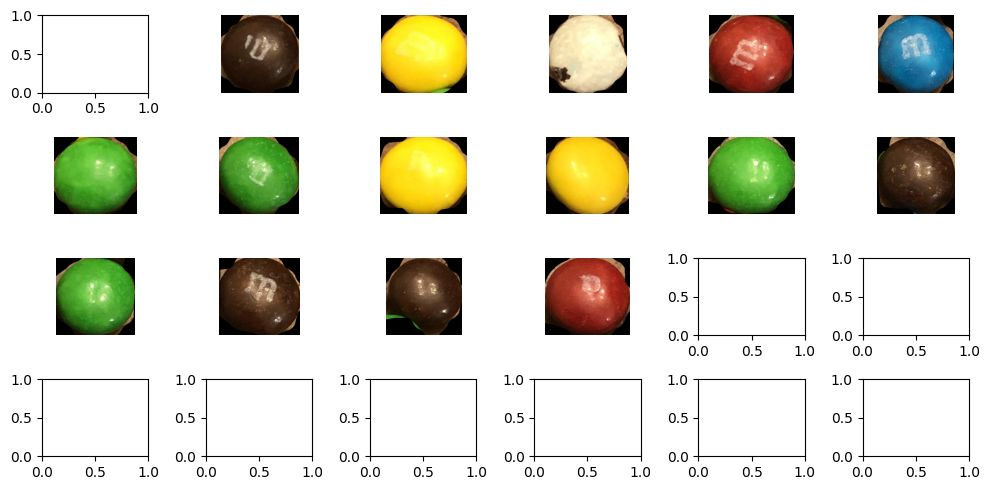

In [4]:
def uploadImage():
    global file_path
    file_path = filedialog.askopenfilename(
        filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")]
    )
    if file_path:
        img = Image.open(file_path)
        img.thumbnail((300, 300))  # Resize the image to fit in the window
        img_tk = ImageTk.PhotoImage(img)
        image_label.config(image=img_tk)
        image_label.image = img_tk
        file_path_label.config(text=f"File: {file_path}")

        # Display some information in the text box
        output_text.delete("1.0", tk.END)  # Clear previous text
        output_text.insert(tk.END, f"File Path: {file_path}\n")
        output_text.insert(tk.END, f"Image Size: {img.size}\n")
        output_text.insert(tk.END, f"Image Format: {img.format}\n")


# Initialize the main window
root = tk.Tk()
root.title("Image and Info Display GUI")
root.geometry("400x600")

# Upload image button
upload_button = ttk.Button(
    root, text="Upload Image", command=uploadImage
)
upload_button.pack(pady=10)

# Upload process button
upload_button = ttk.Button(
    root, text="Process Image", command=lambda: processImage(file_path)
)
upload_button.pack(pady=10)

# Image display label
image_label = tk.Label(root)
image_label.pack(pady=10)

# File path label
file_path_label = tk.Label(root, text="No file selected", wraplength=300)
file_path_label.pack()

# Text box for output information
output_text = tk.Text(root, height=10, width=40, state=tk.NORMAL)
output_text.pack(pady=10)

# Run the main loop
root.mainloop()


Your project report should contain these sections:

- **Introduction**: Detail the motivation and background context explaining why this counting topic was chosen
- **Methods**: Explain how you modified the sample code. If using ML, describe which model was chosen (and why), and how it was integrated into the existing code
- **Results**: Write as a user manual explaining how to use your code. Include:
  * Sample test images
  * A set of documented tests
  * Results in tables and graphs
    * Consider using [numpy](https://numpy.org/) for any mathematical calculation including statistics
    * Consider using [matplotlib](https://matplotlib.org/) for graphs and plots.
    * The combination of [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) simulates the Matlab environment and the syntax are almost identical!
- **Discussion**: Explain:
  * Why you chose your approach
  * What was needed to make it work
  * If issues arose, document the reasons (**It is acceptable if your program doesn't work perfectly** as long as you investigate why)
  * Potential societal/economic implications and impact
- **Conclusion**: Detail what you learned
- **Bibliography**: Provide a list of references relevant to your report. For example, if you use a publicly available ML model, provide a citation/reference to the original paper and the URL where you downloaded the model.

installing:

pip install transformers opencv-python matplotlib
must download this https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view

Introduction:
What's the problem and why do we care.

Method:
We are using the Segment Anything Model. We chose this because of the low barrier to entry, and it's inherent effectiveness with 